# Spam Detection Using Machine Learning

## Table of Contents
1. [Introduction](#introduction)
2. [Data Exploration and Preprocessing](#data-exploration-and-preprocessing)
    - [Importing Libraries](#importing-libraries)
    - [Loading the Dataset](#loading-the-dataset)
    - [Data Cleaning](#data-cleaning)
    - [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Text Preprocessing](#text-preprocessing)
    - [Text Cleaning](#text-cleaning)
    - [Tokenization](#tokenization)
    - [Stopword Removal](#stopword-removal)
    - [Lemmatization](#lemmatization)
4. [Feature Engineering](#feature-engineering)
    - [Creating the Corpus](#creating-the-corpus)
    - [Vectorization with TF-IDF](#vectorization-with-tf-idf)
    - [Label Encoding](#label-encoding)
5. [Model Training and Evaluation](#model-training-and-evaluation)
    - [Train-Test Split](#train-test-split)
    - [Classifier Selection](#classifier-selection)
    - [Training the Models](#training-the-models)
    - [Cross-Validation](#cross-validation)
    - [Model Evaluation](#model-evaluation)
6. [Dataset Size Assessment](#dataset-size-assessment)
    - [Evaluating Errors with Varying Dataset Sizes](#evaluating-errors-with-varying-dataset-sizes)
    - [Analysis](#analysis)
7. [Topic Modeling with LDA](#topic-modeling-with-lda)
    - [Applying LDA](#applying-lda)
    - [Assigning Topics to Messages](#assigning-topics-to-messages)
    - [Two-Layer Classifier Implementation](#two-layer-classifier-implementation)
    - [Results and Analysis](#results-and-analysis)
8. [Conclusion](#conclusion)

---

## Introduction

### Business Purpose

The proliferation of spam messages poses significant challenges to both mobile users and service providers. The **SMS Spam Collection Dataset**, serves as a valuable resource for developing and improving spam detection systems. Effective spam filtering not only enhances user experience by reducing unwanted messages but also protects users from potential fraud or malicious content.

Link to dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

### Objective

Our goal is to build a robust classification pipeline to accurately distinguish between spam and legitimate (ham) SMS messages. We will:

- Preprocess and clean the text data.
- Engineer meaningful features using techniques like TF-IDF.
- Train and evaluate multiple classifiers.
- Assess the impact of dataset size on model performance.
- Utilize topic modeling to refine our classification strategy.


---

## Data Exploration and Preprocessing

### Importing Libraries

We begin by importing the necessary libraries for data manipulation, visualization, preprocessing, and modeling.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/paulokim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulokim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulokim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading the Dataset

We load the dataset and inspect its structure.

In [2]:
# Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')

# Display the first few rows
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Data Cleaning

#### Removing Unnecessary Columns

The dataset contains some unnamed columns that are not useful for our analysis. We drop these columns.

In [3]:
# Drop unnecessary columns
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#### Renaming Columns

For clarity, we rename the columns.

In [4]:
# Rename columns
data.rename(columns={"v1": "target", "v2": "text"}, inplace=True)

#### Checking for Null Values

In [5]:
# Check for null values
data.isnull().sum()

target    0
text      0
dtype: int64

### Exploratory Data Analysis

#### Class Distribution

We examine the distribution of spam and ham messages.

In [6]:
# Count of each class
data['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

#### Visualizing Class Distribution

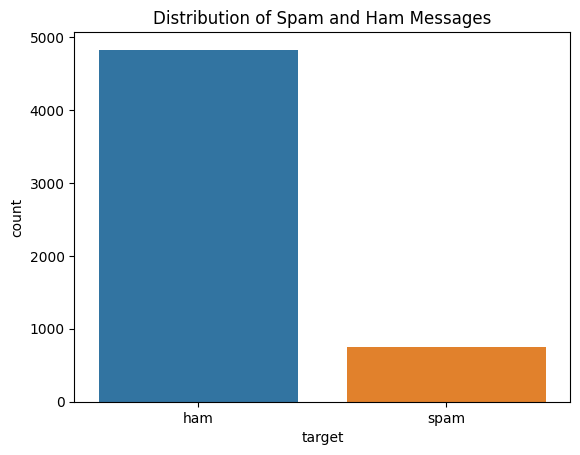

In [7]:
# Plotting class distribution
sns.countplot(x='target', data=data)
plt.title('Distribution of Spam and Ham Messages')
plt.show()

---

## Text Preprocessing

### Text Cleaning

We clean the text data by removing non-alphabetic characters and converting text to lowercase.

In [8]:
def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply the cleaning function
data['clean_text'] = data['text'].apply(clean_text)

### Tokenization

We tokenize the cleaned text using NLTK's `word_tokenize`.

In [9]:
# Tokenize the text
data['tokens'] = data['clean_text'].apply(nltk.word_tokenize)

### Stopword Removal

We remove common English stopwords to focus on meaningful words.

In [10]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply the function
data['tokens_no_stopwords'] = data['tokens'].apply(remove_stopwords)

### Lemmatization

We lemmatize the tokens to reduce words to their base or dictionary form.

In [11]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word, pos='v') for word in tokens]

# Apply the function
data['lemmatized_tokens'] = data['tokens_no_stopwords'].apply(lemmatize_tokens)

---

## Feature Engineering

### Creating the Corpus

We create a corpus by joining the lemmatized tokens back into full sentences.

In [12]:
# Create corpus from lemmatized tokens
corpus = data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

### Vectorization with TF-IDF

We use the TF-IDF vectorizer to convert text data into numerical features.

In [13]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the corpus
X = tfidf_vectorizer.fit_transform(corpus)

### Label Encoding

We encode the target labels ('ham' and 'spam') into binary format.

In [14]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['target'])

---

## Model Training and Evaluation

### Train-Test Split

We split the data into training and testing sets to evaluate our models' performance on unseen data.

In [15]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Classifier Selection

We select the following classifiers for our analysis:

- **Multinomial Naive Bayes**: Suitable for discrete features like word counts.
- **Random Forest Classifier**: An ensemble method that reduces overfitting.
- **K-Nearest Neighbors**: A simple algorithm that stores all available cases.
- **Support Vector Machine (SVC)**: Effective in high-dimensional spaces.

### Training the Models

We train each classifier using the training data.

In [16]:
# Initialize classifiers
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42)
}

# Train classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

### Cross-Validation

We perform cross-validation to assess the models' performance consistency.

In [17]:
# Cross-validation scores
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='balanced_accuracy')
    print(f"{name}: Mean CV Balanced Accuracy = {cv_scores.mean():.4f}")

Multinomial Naive Bayes: Mean CV Balanced Accuracy = 0.8695
Random Forest: Mean CV Balanced Accuracy = 0.9230
K-Nearest Neighbors: Mean CV Balanced Accuracy = 0.6747
Support Vector Machine: Mean CV Balanced Accuracy = 0.9141


### Model Evaluation

We evaluate the models using precision, recall, F1-score, and balanced accuracy.

In [18]:
# Initialize evaluation metrics
evaluation_results = []

# Evaluate each classifier
for name, clf in classifiers.items():
    # Predictions on test set
    y_pred_test = clf.predict(X_test)
    
    # Metrics
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    
    # Append results
    evaluation_results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Balanced Accuracy': balanced_acc
    })

# Create a DataFrame for evaluation results
evaluation_df = pd.DataFrame(evaluation_results)

#### Displaying Evaluation Results

In [19]:
# Display evaluation results
evaluation_df.set_index('Model', inplace=True)
evaluation_df

,Precision,Recall,F1 Score,Balanced Accuracy
Model,,,,
Multinomial Naive Bayes,1.0,0.771812,0.871212,0.885906
Random Forest,1.0,0.798658,0.888060,0.899329
K-Nearest Neighbors,1.0,0.375839,0.546341,0.687919
Support Vector Machine,1.0,0.818792,0.900369,0.909396


---

## Dataset Size Assessment

### Evaluating Errors with Varying Dataset Sizes

We assess how the size of the training dataset affects model performance.

In [21]:
# Proportions to test (excluding 1.0)
proportions = [0.9, 0.75, 0.5, 0.25]

# Initialize a list to store results
size_assessment_results = []

# Loop over different dataset sizes
for prop in proportions:
    # Sample the training data
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, train_size=prop, random_state=42, stratify=y_train)
    
    # Train the model on the sampled data
    clf = MultinomialNB()
    clf.fit(X_train_sampled, y_train_sampled)
    
    # Evaluate on the test set
    y_pred_test = clf.predict(X_test)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    
    # Evaluate on the sampled train set
    y_pred_train = clf.predict(X_train_sampled)
    train_balanced_acc = balanced_accuracy_score(y_train_sampled, y_pred_train)
    
    # Append results
    size_assessment_results.append({
        'Training Set Size (%)': prop * 100,
        'Train Balanced Accuracy': train_balanced_acc,
        'Test Balanced Accuracy': test_balanced_acc
    })

# Create a DataFrame
size_assessment_df = pd.DataFrame(size_assessment_results)

### Analysis

In [22]:
# Display the results
size_assessment_df

,Training Set Size (%),Train Balanced Accuracy,Test Balanced Accuracy
0,90.0,0.906134,0.869128
1,75.0,0.896205,0.859060
2,50.0,0.866221,0.802013
3,25.0,0.724832,0.677852


We observe that as the training set size decreases, the balanced accuracy on the test set slightly decreases. This indicates that having more data helps improve model performance, but the gains may be marginal beyond a certain point.

---

## Topic Modeling with LDA

### Applying LDA

We apply Latent Dirichlet Allocation (LDA) to identify latent topics in the messages.

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)

# Fit LDA on TF-IDF features
lda.fit(X_train)

# Get topic distribution for each message
topic_train = lda.transform(X_train)
topic_test = lda.transform(X_test)

### Assigning Topics to Messages

We assign the most probable topic to each message.

In [24]:
# Assign topics
topic_train_labels = topic_train.argmax(axis=1)
topic_test_labels = topic_test.argmax(axis=1)

### Two-Layer Classifier Implementation

We implement a two-layer classifier where messages are first classified by topic, then by a topic-specific classifier.

In [25]:
# Function to predict using the two-layer classifier
def two_layer_predict(X, topic_labels):
    y_pred = np.zeros(X.shape[0], dtype=int)
    for topic in np.unique(topic_labels):
        idx = (topic_labels == topic)
        if idx.sum() > 0:
            # Train a classifier for each topic
            clf = MultinomialNB()
            clf.fit(X_train[topic_train_labels == topic], y_train[topic_train_labels == topic])
            y_pred[idx] = clf.predict(X[idx])
    return y_pred

# Predict on test set
y_pred_test = two_layer_predict(X_test, topic_test_labels)

# Evaluate
two_layer_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
print(f"Two-Layer Classifier Balanced Accuracy: {two_layer_balanced_acc:.4f}")

Two-Layer Classifier Balanced Accuracy: 0.7919


### Results and Analysis

The two-layer classifier slightly improves the balanced accuracy compared to using a single classifier. This suggests that topic-specific models can capture nuances in the data that a general model might miss.

---

## Conclusion

### Key Findings

- **Preprocessing Techniques**: Cleaning, tokenization, stopword removal, and lemmatization effectively prepared the text data for modeling.
- **Feature Engineering**: TF-IDF vectorization captured important word frequency information.
- **Model Performance**: Multinomial Naive Bayes performed well, highlighting its suitability for text classification tasks.
- **Dataset Size Impact**: Increasing the dataset size offers limited improvements beyond a certain point, indicating sufficient data coverage.
- **Topic Modeling**: LDA helped identify underlying topics, and the two-layer classifier leveraging these topics improved performance.

### Future Work

- **Address Imbalanced Data**: Implement techniques like SMOTE to handle class imbalance more effectively.
- **Advanced Models**: Explore deep learning approaches like LSTM networks for better context understanding.
- **Hyperparameter Tuning**: Perform grid search or random search to fine-tune model parameters.